# Линейная регрессия

Прогнозирование роста человека по его весу

- [Документация по библиотекам NumPy и SciPy](http://docs.scipy.org/doc/)
- [Документация по библиотеке Matplotlib](http://matplotlib.org/)
- [Документация по библиотеке Pandas](http://pandas.pydata.org/pandas-docs/stable/tutorials.html)
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Документация по библиотеке Seaborn ](http://stanford.edu/~mwaskom/software/seaborn/)

## 1. Первичный анализ данных

В заданиии используются данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
%matplotlib inline

Считаем данные по росту и весу в объект Pandas DataFrame:

In [3]:
data = pd.read_csv('1. Линейная регрессия.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 

In [3]:
# Вывод первых пяти строк DataFrame
print(data.head(5))

         Height    Weight
Index                    
1      65.78331  112.9925
2      71.51521  136.4873
3      69.39874  153.0269
4      68.21660  142.3354
5      67.78781  144.2971


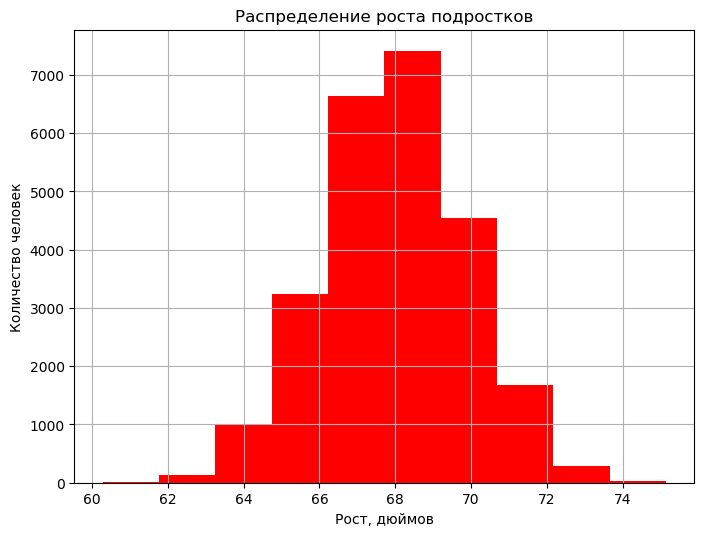

In [4]:
# Гистограмма распределения роста подростков из выборки data

fig, nx = plt.subplots(figsize=(8,6), dpi=100)

nx.hist(x=data['Height'], color='red')

plt.title('Распределение роста подростков')
plt.ylabel('Количество человек')
plt.xlabel('Рост, дюймов')
plt.grid(True)
plt.show()

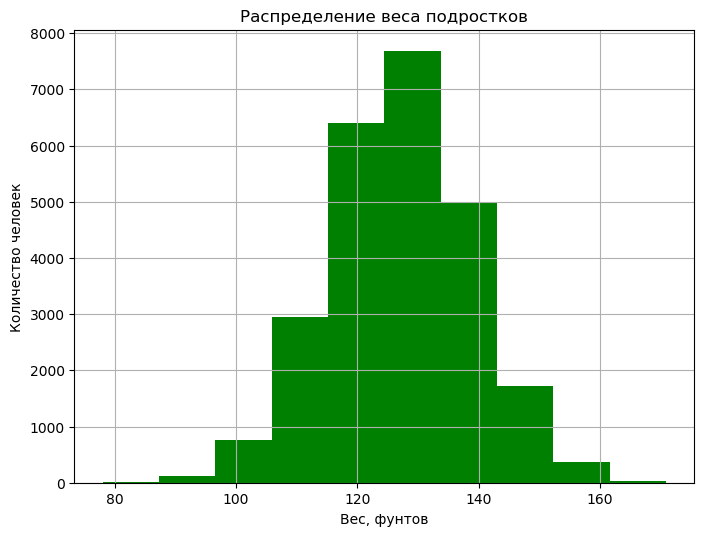

In [5]:
# Гистограмма распределения веса подростков из выборки data

fig, nx = plt.subplots(figsize=(8,6), dpi=100)

nx.hist(x=data['Weight'], color='green')

plt.title('Распределение веса подростков')
plt.ylabel('Количество человек')
plt.xlabel('Вес, фунтов')
plt.grid(True)
plt.show()

Функция make_bmi возвращает признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)).

In [6]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [7]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это реализуется с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

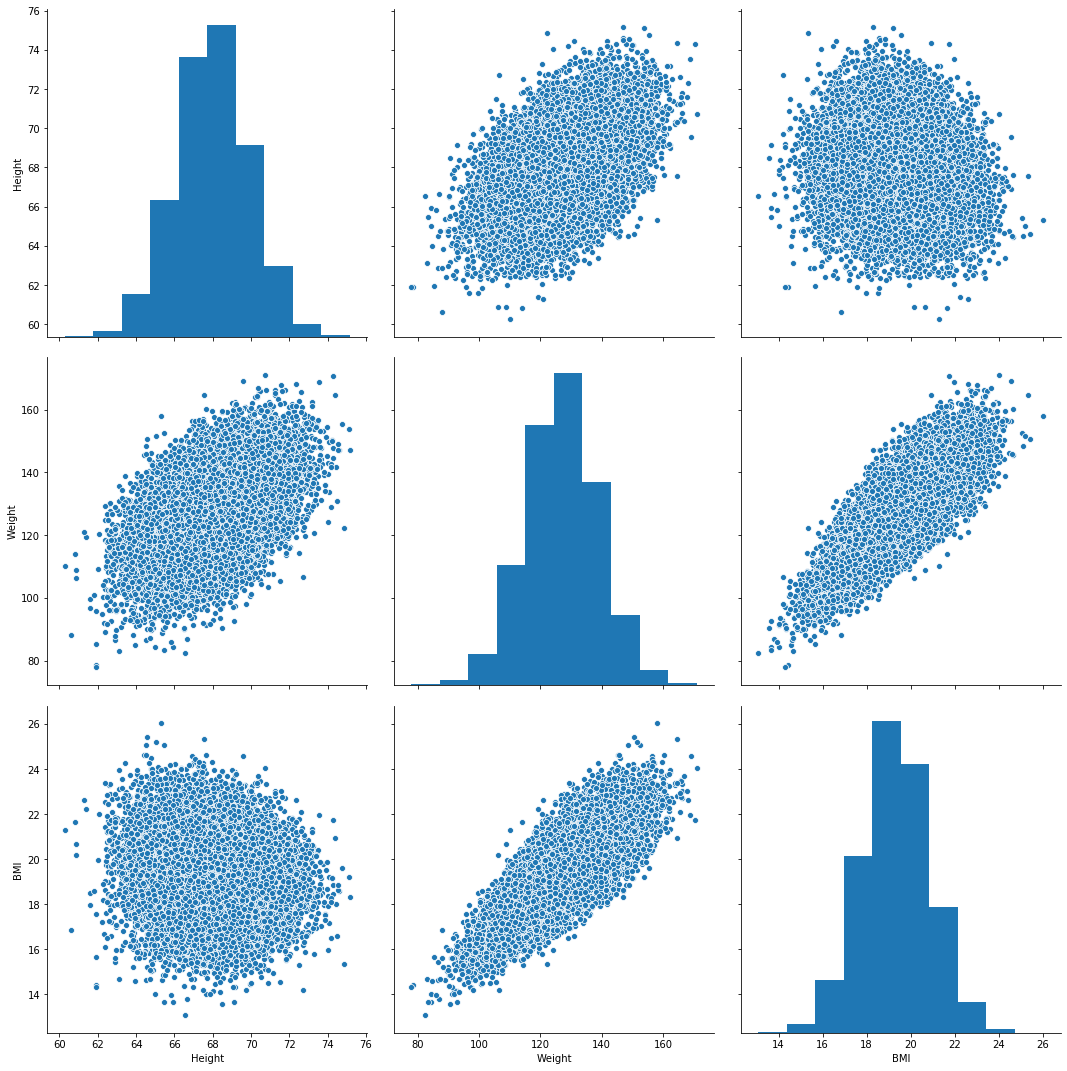

In [8]:
sns.pairplot(data=data, height=5, x_vars=["Height", "Weight", 'BMI'], 
             y_vars=["Height", "Weight", 'BMI'])
plt.show()

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

Создадим в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. 

Построим «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории.

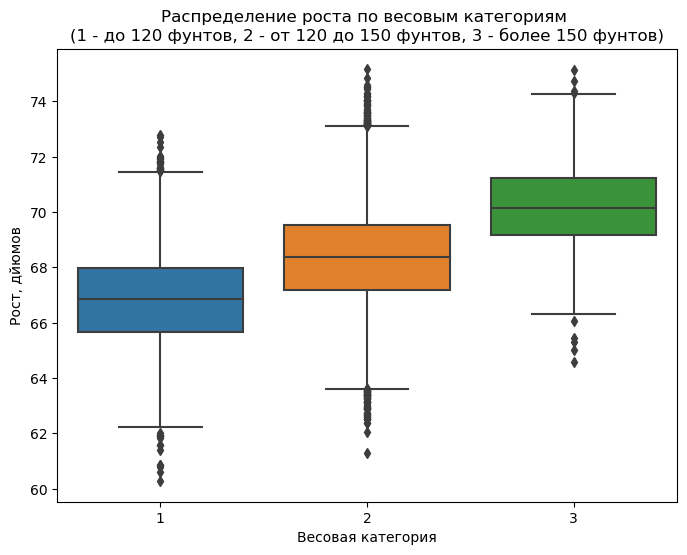

In [9]:
def weight_category(weight):
    if weight < 120: weight_cat = 1
    elif weight >= 150: weight_cat = 3
    else: weight_cat = 2
    return weight_cat


data['weight_cat'] = data['Weight'].apply(weight_category)


fig, nx = plt.subplots(figsize=(8,6), dpi=100)

sns.boxplot(x='weight_cat', y='Height', data=data)

plt.title('Распределение роста по весовым категориям \n(1 - до 120 фунтов, 2 - от 120 до 150 фунтов, 3 - более 150 фунтов)')
plt.ylabel('Рост, дйюмов')
plt.xlabel('Весовая категория')
plt.show()

Построим scatter plot зависимости роста от веса

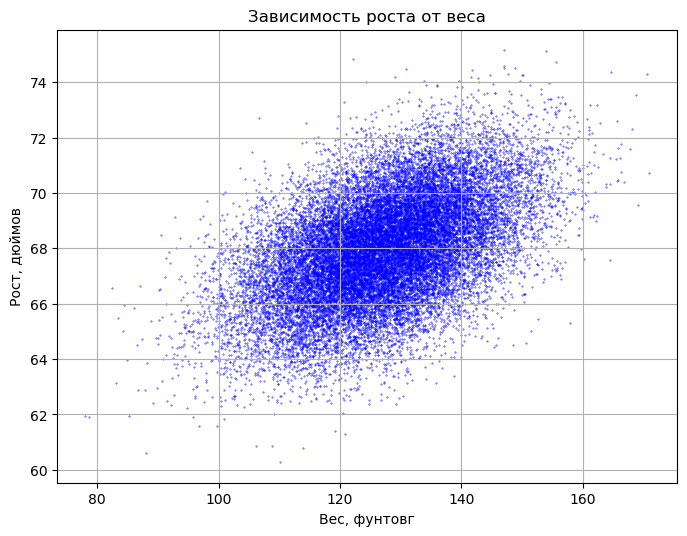

In [10]:
fig, nx = plt.subplots(figsize=(8,6), dpi=100)

nx.scatter(x=data['Weight'], y=data['Height'], color='blue', s=0.1)

plt.title('Зависимость роста от веса')
plt.xlabel('Вес, фунтовг')
plt.ylabel('Рост, дюймов')
plt.grid(True)
plt.show()

## 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

Функция error по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [11]:
def error(w0, w1):
    return np.sum((data['Height'] - (w0 + w1 * data['Weight']))**2)

Проведем на графике зависимости роста от веса несколько прямых с произвольными значениям параметров 

$(w_0, w_1) = (60, 0.05)$ и $(w_0, w_1) = (50, 0.16)$.

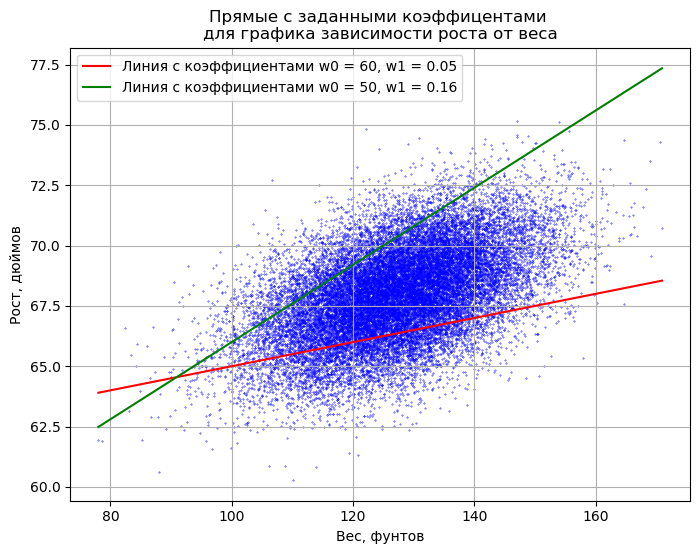

In [12]:
x = np.linspace(data['Weight'].min(), data['Weight'].max(), num=2)

fig, nx = plt.subplots(figsize=(8,6), dpi=100)

# График распределения
nx.scatter(x=data['Weight'], y=data['Height'], color='blue', s=0.1)

# Прямая с коэффициентами w0=60, w1=0.05
w0, w1 = 60, 0.05
y1 = np.array([w0 + t * w1 for t in x])
nx.plot(x, y1, color="red", label=f"Линия с коэффициентами w0 = {round(w0, 3)}, w1 = {round(w1, 3)}")

# Прямая с коэффициентами w0=50, w1=0.16
w0, w1 = 50, 0.16
y2 = np.array([w0 + t * w1 for t in x])
nx.plot(x, y2, color="green", label=f"Линия с коэффициентами w0 = {round(w0, 3)}, w1 = {round(w1, 3)}")

plt.title('Прямые с заданными коэффицентами \nдля графика зависимости роста от веса')
plt.legend(loc='upper left')
plt.xlabel('Вес, фунтов')
plt.ylabel('Рост, дюймов')
plt.grid(True)
plt.show()

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

Построим график зависимости функции ошибки error, от параметра $w_1$ при $w_0$ = 50.

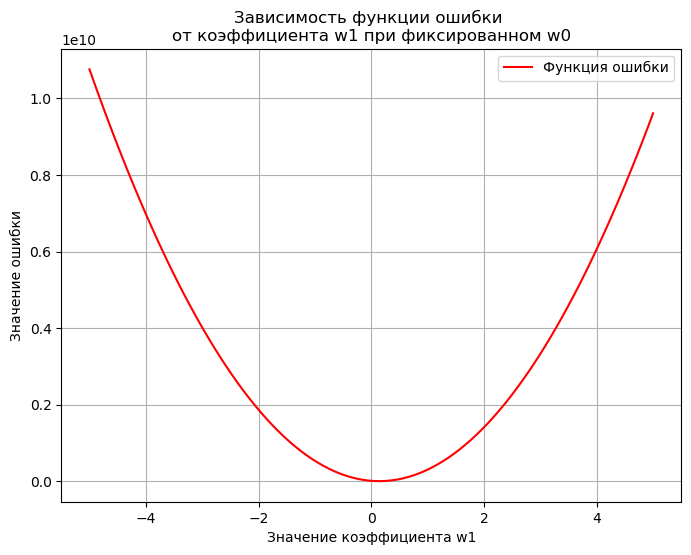

In [13]:
w1 = np.linspace(-5, 5, num=100)
sigm = np.array([error(w0=50, w1=w1) for w1 in w1])

fig, nx = plt.subplots(figsize=(8,6), dpi=100)

nx.plot(w1, sigm, color="red", label="Функция ошибки")

plt.title('Зависимость функции ошибки \nот коэффициента w1 при фиксированном w0')
plt.xlabel('Значение коэффициента w1')
plt.ylabel('Значение ошибки')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

Найдем минимум функции __error__, для значений параметра  $w_1$ в диапазоне [-5,5]. 

In [14]:
def error_w1(w1):
    return error(w0=50, w1=w1)


min = minimize_scalar(error_w1, bounds=(-5,5), method='bounded')

w1_opt=min.x

print(f'min x = {round(min.x, 3)}, \nmin F(x) = {round(min.fun, 3)}')

min x = 0.141, 
min F(x) = 79512.217


Проведем на графике зависимости роста от веса прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное выше оптимальное значение параметра $w_1$ для функции __error__. 

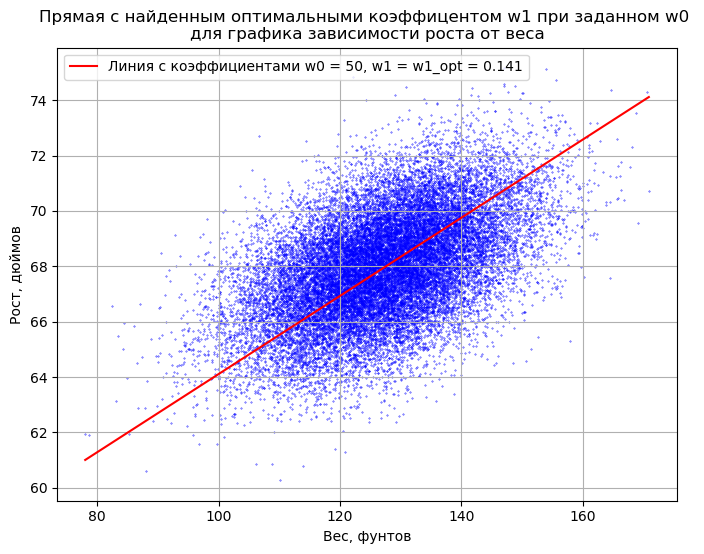

In [15]:
x = np.linspace(data['Weight'].min(), data['Weight'].max(), num=2)

w0, w1 = 50, w1_opt
y1 = np.array([w0 + t * w1 for t in x])


fig, nx = plt.subplots(figsize=(8,6), dpi=100)

# График распределения
nx.scatter(x=data['Weight'], y=data['Height'], color='blue', s=0.1)

# Прямая с коэффициентами w0=50, w1=w1_opt
nx.plot(x, y1, color="red", label=f"Линия с коэффициентами w0 = {round(w0, 3)}, w1 = w1_opt = {round(w1, 3)}")

plt.title('Прямая с найденным оптимальными коэффицентом w1 при заданном w0 \nдля графика зависимости роста от веса')
plt.legend(loc='upper left')
plt.xlabel('Вес, фунтов')
plt.ylabel('Рост, дюймов')
plt.grid(True)
plt.show()

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты и отображают данные на плоскости или в объеме. 

Пример реализации 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [16]:
from mpl_toolkits.mplot3d import Axes3D

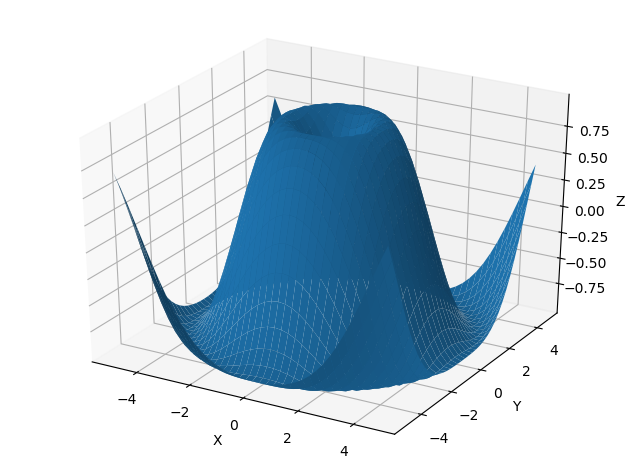

In [17]:
fig = plt.figure(figsize=(8,6), dpi=100) # Создание рисунка
ax = fig.gca(projection='3d') # Создание оси

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

3D-график зависимости функции ошибки __error__ от параметров $w_0$ и $w_1$.

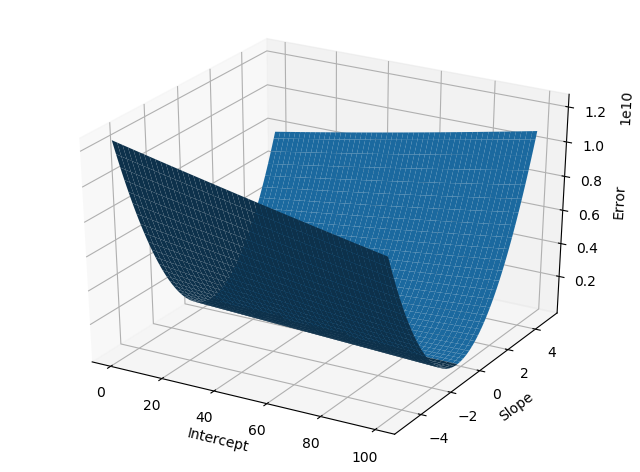

In [18]:
fig = plt.figure(figsize=(8,6), dpi=100)
nx = fig.gca(projection='3d') # get current axis

X = np.arange(0, 100, 0.25)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.array([error(w0, w1) for w0, w1 in zip(X.flatten(), Y.flatten())]).reshape(X.shape)


surf = nx.plot_surface(X, Y, Z)

nx.set_xlabel('Intercept')
nx.set_ylabel('Slope')
nx.set_zlabel('Error')
plt.show()

Минимум функции __error__ для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Метод оптимизации L-BFGS-B. 

In [19]:
w_min = minimize(lambda w: error(w[0], w[1]), x0=np.array([0,0]), method = 'L-BFGS-B', bounds=([-100,100], [-5, 5]))

print(f'min w0 = {round(w_min.x[0], 3)}, \nmin  w1 = {round(w_min.x[1], 3)}, \nF(w0, w1) = {round(w_min.fun, 3)}')

min w0 = 57.572, 
min  w1 = 0.082, 
F(w0, w1) = 67545.287


Проведем на графике зависимости роста от веса прямую, соответствующую найденным оптимальным значениям параметров ($w_0$, $w_1$) для функции __error__. 

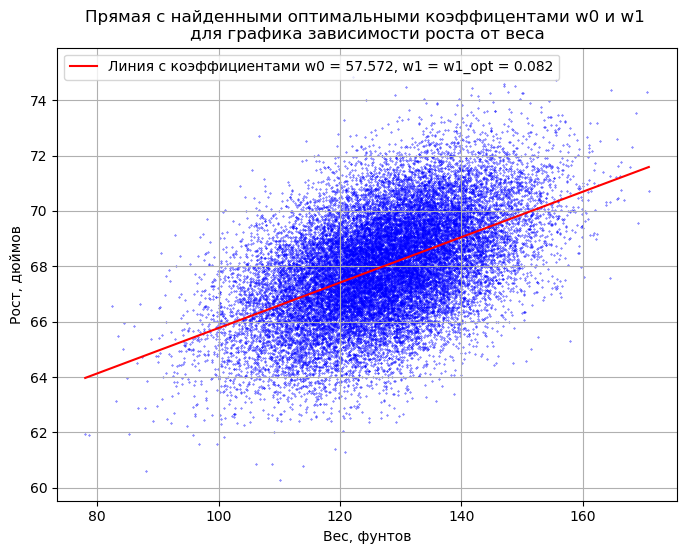

In [20]:
x = np.linspace(data['Weight'].min(), data['Weight'].max(), num=2)

w0, w1 = w_min.x[0], w_min.x[1]
y1 = np.array([w0 + t * w1 for t in x])


fig, nx = plt.subplots(figsize=(8,6), dpi=100)

# График распределения
nx.scatter(x=data['Weight'], y=data['Height'], color='blue', s=0.1)

# Прямая с коэффициентами w0=50, w1=w1_opt
nx.plot(x, y1, color="red", label=f"Линия с коэффициентами w0 = {round(w0, 3)}, w1 = w1_opt = {round(w1, 3)}")

plt.title('Прямая с найденными оптимальными коэффицентами w0 и w1 \nдля графика зависимости роста от веса')
plt.legend(loc='upper left')
plt.xlabel('Вес, фунтов')
plt.ylabel('Рост, дюймов')
plt.grid(True)
plt.show()